In [153]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelBinarizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error as m_a_e, mean_squared_error as m_s_e, r2_score as r2
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import GradientBoostingRegressor

from scipy.stats.mstats import winsorize

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
dataset = "E:/Formation Data Scientist/Projet_4/2016_Building_Energy_Benchmarking.csv"

In [4]:
df = pd.read_csv(dataset)

### <a name='C2'> EDA et Choix des features   </a>

In [5]:
df.head(3)

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,...,1.156514e+06,3946027.0,12764.52930,1276453.0,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,...,9.504252e+05,3242851.0,51450.81641,5145082.0,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,...,1.451544e+07,49526664.0,14938.00000,1493800.0,False,NaN,Compliant,NaN,2089.28,2.19


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3376 non-null   int64  
 1   DataYear                         3376 non-null   int64  
 2   BuildingType                     3376 non-null   object 
 3   PrimaryPropertyType              3376 non-null   object 
 4   PropertyName                     3376 non-null   object 
 5   Address                          3376 non-null   object 
 6   City                             3376 non-null   object 
 7   State                            3376 non-null   object 
 8   ZipCode                          3360 non-null   float64
 9   TaxParcelIdentificationNumber    3376 non-null   object 
 10  CouncilDistrictCode              3376 non-null   int64  
 11  Neighborhood                     3376 non-null   object 
 12  Latitude            

In [7]:
df.shape

(3376, 46)

- Exploration des valeurs nulles

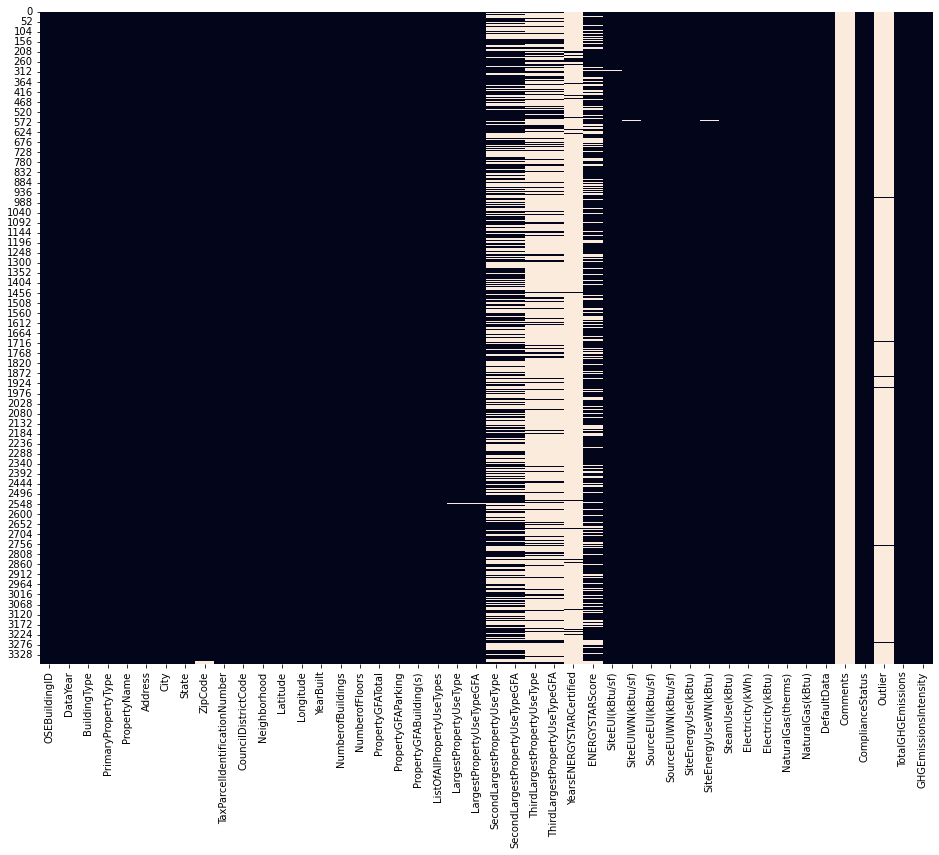

In [8]:
plt.figure(figsize=(16,12))
sns.heatmap(df.isna(),cbar=False)
plt.show()

- Typologie des variables

In [9]:
df.dtypes.value_counts()

float64    22
object     15
int64       8
bool        1
dtype: int64

- Nombre de variables différentes par Feature

In [10]:
df.nunique()

OSEBuildingID                      3376
DataYear                              1
BuildingType                          8
PrimaryPropertyType                  24
PropertyName                       3362
Address                            3354
City                                  1
State                                 1
ZipCode                              55
TaxParcelIdentificationNumber      3268
CouncilDistrictCode                   7
Neighborhood                         19
Latitude                           2876
Longitude                          2656
YearBuilt                           113
NumberofBuildings                    17
NumberofFloors                       50
PropertyGFATotal                   3195
PropertyGFAParking                  496
PropertyGFABuilding(s)             3193
ListOfAllPropertyUseTypes           466
LargestPropertyUseType               56
LargestPropertyUseTypeGFA          3122
SecondLargestPropertyUseType         50
SecondLargestPropertyUseTypeGFA    1352


In [11]:
df['Outlier'].value_counts()

Low outlier     23
High outlier     9
Name: Outlier, dtype: int64

In [12]:
df['ComplianceStatus'].value_counts()

Compliant                       3211
Error - Correct Default Data     113
Non-Compliant                     37
Missing Data                      15
Name: ComplianceStatus, dtype: int64

On a 8 types de buiding, seuls les buildings résidentiels nous interressent dans le cadre de notre étude

In [13]:
df.iloc[:,2].value_counts()

NonResidential          1460
Multifamily LR (1-4)    1018
Multifamily MR (5-9)     580
Multifamily HR (10+)     110
SPS-District K-12         98
Nonresidential COS        85
Campus                    24
Nonresidential WA          1
Name: BuildingType, dtype: int64

Ici ce sont les buildings de type Multifamily qui nous interressent (rajouter Campus??)

In [14]:
df.iloc[:,3].value_counts()

Low-Rise Multifamily           987
Mid-Rise Multifamily           564
Small- and Mid-Sized Office    293
Other                          256
Warehouse                      187
Large Office                   173
K-12 School                    139
Mixed Use Property             133
High-Rise Multifamily          105
Retail Store                    91
Hotel                           77
Worship Facility                71
Distribution Center             53
Senior Care Community           45
Supermarket / Grocery Store     40
Medical Office                  39
Self-Storage Facility           28
University                      25
Residence Hall                  23
Refrigerated Warehouse          12
Restaurant                      12
Hospital                        10
Laboratory                      10
Office                           3
Name: PrimaryPropertyType, dtype: int64

- Nombre de valeures nulles par feature

In [15]:
df.isna().sum()

OSEBuildingID                         0
DataYear                              0
BuildingType                          0
PrimaryPropertyType                   0
PropertyName                          0
Address                               0
City                                  0
State                                 0
ZipCode                              16
TaxParcelIdentificationNumber         0
CouncilDistrictCode                   0
Neighborhood                          0
Latitude                              0
Longitude                             0
YearBuilt                             0
NumberofBuildings                     8
NumberofFloors                        0
PropertyGFATotal                      0
PropertyGFAParking                    0
PropertyGFABuilding(s)                0
ListOfAllPropertyUseTypes             9
LargestPropertyUseType               20
LargestPropertyUseTypeGFA            20
SecondLargestPropertyUseType       1697
SecondLargestPropertyUseTypeGFA    1697


In [16]:
building_type = ['NonResidential','NonResidential COS','NonResidential WA'] # Réflechir sur rajouter ou non Campus comme building résidentiel,'Campus','SPS-District K-12',

nonResidential = df[df['BuildingType'].isin(building_type)].reset_index(drop=True)

- Nos deux targets sont **TotalGHGEmissions** et **SiteEnergyUse(kBtu)**

In [17]:
compliant = ['Compliant']

nonResidential = nonResidential[nonResidential['ComplianceStatus'].isin(compliant)].reset_index(drop=True)

In [18]:
nonResidential.shape

(1432, 46)

In [19]:
nonResidential.iloc[:,3].value_counts()

Small- and Mid-Sized Office    282
Other                          181
Warehouse                      178
Large Office                   164
Mixed Use Property             101
Retail Store                    85
Hotel                           75
Worship Facility                69
Distribution Center             51
Supermarket / Grocery Store     40
Medical Office                  38
K-12 School                     38
Self-Storage Facility           28
Residence Hall                  21
Senior Care Community           20
University                      17
Refrigerated Warehouse          12
Restaurant                      11
Hospital                        10
Laboratory                      10
Low-Rise Multifamily             1
Name: PrimaryPropertyType, dtype: int64

- Nettoyage et choix des features à utiliser

In [20]:
nonResidential = nonResidential.drop(nonResidential[nonResidential['PrimaryPropertyType'] == 'Low-Rise Multifamily'].index)

In [21]:
nonResidential = nonResidential.drop(nonResidential[nonResidential['PrimaryPropertyType'] == 'Residence Hall'].index)

In [22]:
nonResidential.iloc[:,3].value_counts()

Small- and Mid-Sized Office    282
Other                          181
Warehouse                      178
Large Office                   164
Mixed Use Property             101
Retail Store                    85
Hotel                           75
Worship Facility                69
Distribution Center             51
Supermarket / Grocery Store     40
K-12 School                     38
Medical Office                  38
Self-Storage Facility           28
Senior Care Community           20
University                      17
Refrigerated Warehouse          12
Restaurant                      11
Hospital                        10
Laboratory                      10
Name: PrimaryPropertyType, dtype: int64

In [23]:
nonResidential.isna().sum()

OSEBuildingID                         0
DataYear                              0
BuildingType                          0
PrimaryPropertyType                   0
PropertyName                          0
Address                               0
City                                  0
State                                 0
ZipCode                               0
TaxParcelIdentificationNumber         0
CouncilDistrictCode                   0
Neighborhood                          0
Latitude                              0
Longitude                             0
YearBuilt                             0
NumberofBuildings                     0
NumberofFloors                        0
PropertyGFATotal                      0
PropertyGFAParking                    0
PropertyGFABuilding(s)                0
ListOfAllPropertyUseTypes             0
LargestPropertyUseType                4
LargestPropertyUseTypeGFA             4
SecondLargestPropertyUseType        633
SecondLargestPropertyUseTypeGFA     633


In [24]:
nonResidential['ComplianceStatus'].value_counts()

Compliant    1410
Name: ComplianceStatus, dtype: int64

In [25]:
nonResidential['Outlier'].value_counts()

Series([], Name: Outlier, dtype: int64)

In [26]:
nonResidential = nonResidential[nonResidential.Outlier.isnull()]

In [27]:
nonResidential = nonResidential[['PrimaryPropertyType','Latitude','Longitude','YearBuilt','NumberofBuildings','NumberofFloors'\
            ,'PropertyGFABuilding(s)','PropertyGFAParking','LargestPropertyUseTypeGFA','SteamUse(kBtu)','Electricity(kBtu)','NaturalGas(kBtu)','TotalGHGEmissions']]

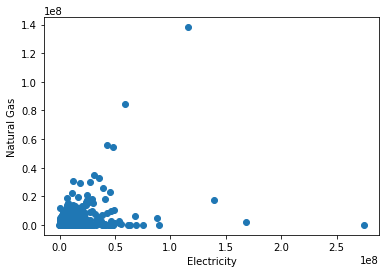

In [28]:
plt.scatter(nonResidential['Electricity(kBtu)'],nonResidential['NaturalGas(kBtu)'])
plt.xlabel('Electricity')
plt.ylabel('Natural Gas')
plt.show()

In [29]:
nonResidential.isna().sum()

PrimaryPropertyType          0
Latitude                     0
Longitude                    0
YearBuilt                    0
NumberofBuildings            0
NumberofFloors               0
PropertyGFABuilding(s)       0
PropertyGFAParking           0
LargestPropertyUseTypeGFA    4
SteamUse(kBtu)               0
Electricity(kBtu)            0
NaturalGas(kBtu)             0
TotalGHGEmissions            0
dtype: int64

In [30]:
nonResidential = nonResidential.dropna(axis=0) 

In [31]:
nonResidential['NumberofBuildings'].value_counts()

1.0    1329
0.0      44
2.0      11
3.0      10
6.0       4
5.0       3
4.0       2
9.0       1
7.0       1
8.0       1
Name: NumberofBuildings, dtype: int64

- Calcul de l'age des batiments

In [32]:
df1 = nonResidential.copy()

In [33]:
def fill_date(data):
    if data<= 1920:
        return "_1920"
    elif 1920<data<=1940:
        return "1920_1940"
    elif 1940<data<=1960:
        return "1940_1960"
    elif 1960<data<=1980:
        return "1960_1980"
    elif 1980<data<=2000:
        return "1980_2000"
    elif data>2000:
        return "2000_"

In [34]:
df1['YearBuilt'] = df1['YearBuilt'].apply(fill_date)

In [35]:
df1['SteamUse(kBtu)'] = df1['SteamUse(kBtu)'].apply(lambda x : 1 if x > 0 else 0 )
df1['Electricity(kBtu)'] = df1['Electricity(kBtu)'].apply(lambda x : 1 if x > 0 else 0 )
df1['NaturalGas(kBtu)'] = df1['NaturalGas(kBtu)'].apply(lambda x : 1 if x > 0 else 0 )

In [36]:
df2_code = pd.get_dummies(df1 ,columns=['PrimaryPropertyType','YearBuilt'])

In [115]:
train, test = train_test_split(df2_code, test_size=0.3, random_state=10) 

In [78]:
X_train, y_train, X_test, y_test = train.drop(columns = "TotalGHGEmissions"), train["TotalGHGEmissions"],test.drop(columns = "TotalGHGEmissions") ,test["TotalGHGEmissions"]

In [79]:
r_forest = RandomForestRegressor(random_state=0)

In [80]:
# entrainement du modèle
r_forest.fit(X_train, y_train)

RandomForestRegressor(random_state=0)

In [81]:
# prédiction
preds = r_forest.predict(X_test)

# calcul du RMSE
print(m_s_e(y_test,preds, squared=False))

316.6531540736589


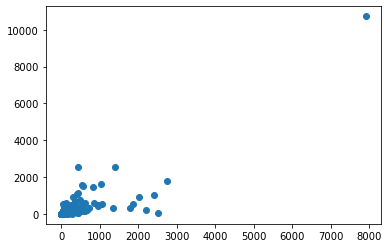

In [82]:
plt.scatter(preds,y_test)

In [83]:
def get_error(n_estimator, X_train, X_test, y_train, y_test):
    model = RandomForestRegressor(n_estimators=n_estimator, random_state=0)
    model.fit(X_train, y_train)
    preds_val = model.predict(X_test)
    rmse = m_s_e(y_test, preds_val,squared=False)
    mae = m_a_e(y_test, preds_val)
    r_2 = r2(y_test,preds_val)
    return(rmse, mae, r_2)

In [84]:
def get_dummy_error(strategy, X_train, X_test, y_train, y_test):
    model = DummyRegressor(strategy=strategy)
    model.fit(X_train, y_train)
    preds_val = model.predict(X_test)
    rmse = m_s_e(y_test, preds_val,squared=False)
    mae = m_a_e(y_test, preds_val)
    r_2 = r2(y_test,preds_val)
    return(rmse, mae, r_2)

In [85]:
# comparer RMSE et r2 avec differents valeurs de n_estimator
lst_rmse = []
lst_mae = []
lst_r2 = []
for strategy in ['mean', 'median']:
    my_rmse = get_dummy_error(strategy, X_train, X_test, y_train, y_test)
    lst_rmse.append(my_rmse[0])
    lst_mae.append(my_rmse[1])
    lst_r2.append(my_rmse[2])
    print("strategy: %s  \t\t RMSE:  %f  \t\t MAE: %f  \t\t R2:  %f" %(strategy, my_rmse[0], my_rmse[1], my_rmse[2]))

strategy: mean  		 RMSE:  587.754537  		 MAE: 188.531540  		 R2:  -0.000113
strategy: median  		 RMSE:  599.508725  		 MAE: 143.741825  		 R2:  -0.040514


In [86]:
# comparer RMSE et r2 avec differents valeurs de n_estimator
lst_rmse = []
lst_mae = []
lst_r2 = []
for n_estimator in [100, 200, 300, 400, 500]:
    my_rmse = get_error(n_estimator, X_train, X_test, y_train, y_test)
    lst_rmse.append(my_rmse[0])
    lst_mae.append(my_rmse[1])
    lst_r2.append(my_rmse[2])
    print("N_Estimator: %d  \t\t RMSE:  %f  \t\t MAE: %f  \t\t R2:  %f" %(n_estimator, my_rmse[0], my_rmse[1], my_rmse[2]))

N_Estimator: 100  		 RMSE:  316.653154  		 MAE: 116.100057  		 R2:  0.709715
N_Estimator: 200  		 RMSE:  324.984572  		 MAE: 117.226858  		 R2:  0.694239
N_Estimator: 300  		 RMSE:  323.581833  		 MAE: 117.557896  		 R2:  0.696873
N_Estimator: 400  		 RMSE:  318.383983  		 MAE: 116.458528  		 R2:  0.706533
N_Estimator: 500  		 RMSE:  317.596023  		 MAE: 116.739072  		 R2:  0.707984


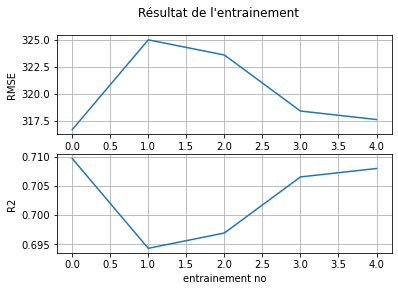

In [87]:
fig,(ax1,ax2) = plt.subplots(2,1)
fig.suptitle('Résultat de l\'entrainement')

ax1.plot(lst_rmse)
ax1.set_ylabel('RMSE')
ax1.set_xlabel('entrainement no')
ax1.grid()

ax2.plot(lst_r2)
ax2.set_ylabel('R2')
ax2.set_xlabel('entrainement no')
ax2.grid()

plt.show()

### - Dummy Resgressor

In [88]:
dummy_param_grid = {'strategy' : ['mean','median']}

In [89]:
CV_dummy_mean = GridSearchCV(estimator=DummyRegressor(), param_grid=dummy_param_grid, cv= 5,scoring='r2')
CV_dummy_mean.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DummyRegressor(),
             param_grid={'strategy': ['mean', 'median']}, scoring='r2')

In [90]:
CV_dummy_mean.best_score_

-0.024135399164125194

In [91]:
dummy_model = CV_dummy_mean.best_estimator_

In [92]:
dummy_model.score(X_test,y_test)

-0.00011283286795671366

In [93]:
pd.DataFrame(CV_dummy_mean.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_strategy,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.001485,0.000222,0.000615,0.000193,mean,{'strategy': 'mean'},-0.010375,-0.079476,-0.000762,-0.003946,-0.026119,-0.024135,0.029017,1
1,0.002055,0.001046,0.000689,0.000215,median,{'strategy': 'median'},-0.037629,-0.186226,-0.071255,-0.041990,-0.131254,-0.093671,0.057084,2


### - Random Forest Resgressor


In [129]:
rfc_param_grid = {'n_estimators' : [100,200,300,400,500],
              'max_features': ['auto', 'sqrt', 'log2'],
              'max_depth' : [4,8,16,32,64],
              'random_state': [12]}

In [130]:
CV_rfc = GridSearchCV(estimator=RandomForestRegressor(), param_grid=rfc_param_grid, cv= 5,scoring=['r2'],refit='r2')
CV_rfc.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [4, 8, 16, 32, 64],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [100, 200, 300, 400, 500],
                         'random_state': [12]},
             refit='r2', scoring=['r2'])

In [131]:
CV_rfc.best_params_

{'max_depth': 32,
 'max_features': 'sqrt',
 'n_estimators': 100,
 'random_state': 12}

In [132]:
CV_rfc.best_score_

0.6313452864582934

In [133]:
model = CV_rfc.best_estimator_

In [134]:
model.score(X_test,y_test)

0.7545265960782539

In [135]:
pd.DataFrame(model.feature_importances_)

,0
0,0.037755
1,0.055060
2,0.160578
3,0.059358
4,0.179056
5,0.011379
6,0.163703
7,0.016788
8,0.000008
9,0.012321


In [136]:
pd.DataFrame(CV_rfc.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_n_estimators,param_random_state,params,split0_test_r2,split1_test_r2,split2_test_r2,split3_test_r2,split4_test_r2,mean_test_r2,std_test_r2,rank_test_r2
0,0.193464,0.015530,0.008140,0.000408,4,auto,100,12,"{'max_depth': 4, 'max_features': 'auto', 'n_es...",0.614140,0.425831,0.475099,0.529999,0.374154,0.483845,0.083164,74
1,0.368575,0.010814,0.014250,0.000754,4,auto,200,12,"{'max_depth': 4, 'max_features': 'auto', 'n_es...",0.615223,0.431633,0.431646,0.509514,0.394342,0.476472,0.078878,75
2,0.609181,0.029603,0.021430,0.000795,4,auto,300,12,"{'max_depth': 4, 'max_features': 'auto', 'n_es...",0.619129,0.438878,0.485169,0.507403,0.399035,0.489923,0.074684,72
3,0.834277,0.023541,0.030661,0.002481,4,auto,400,12,"{'max_depth': 4, 'max_features': 'auto', 'n_es...",0.625115,0.437644,0.497359,0.513892,0.396936,0.494189,0.077711,71
4,0.953214,0.024945,0.035174,0.005252,4,auto,500,12,"{'max_depth': 4, 'max_features': 'auto', 'n_es...",0.623314,0.434975,0.468432,0.528709,0.394049,0.489896,0.079963,73
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,0.170101,0.001879,0.010361,0.000416,64,log2,100,12,"{'max_depth': 64, 'max_features': 'log2', 'n_e...",0.532829,0.601635,0.800467,0.670640,0.505751,0.622265,0.105921,5
71,0.334345,0.003499,0.019578,0.000371,64,log2,200,12,"{'max_depth': 64, 'max_features': 'log2', 'n_e...",0.537431,0.588428,0.819518,0.635807,0.519152,0.620067,0.107742,7
72,0.504728,0.004475,0.027467,0.000558,64,log2,300,12,"{'max_depth': 64, 'max_features': 'log2', 'n_e...",0.543149,0.591241,0.819457,0.599565,0.504045,0.611492,0.109560,13
73,0.698118,0.039564,0.036462,0.000751,64,log2,400,12,"{'max_depth': 64, 'max_features': 'log2', 'n_e...",0.541073,0.592627,0.815156,0.602559,0.506195,0.611522,0.107667,11


### - Ridge Regressor

In [137]:
ridge_param_grid = {'alpha' : [1e-3, 1e-2, 1e-1, 1, 2, 5, 10],
              }

In [138]:
CV_ridge = GridSearchCV(estimator=Ridge(), param_grid=ridge_param_grid, cv= 6,scoring='r2')
CV_ridge.fit(X_train, y_train)

GridSearchCV(cv=6, estimator=Ridge(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 1, 2, 5, 10]},
             scoring='r2')

In [139]:
CV_ridge.best_score_

0.49700082432752973

In [140]:
model_ridge = CV_ridge.best_estimator_
print(model_ridge)

Ridge(alpha=0.1)


In [141]:
model_ridge.score(X_test,y_test)

0.6642685252901456

In [142]:
pd.DataFrame(CV_ridge.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,mean_test_score,std_test_score,rank_test_score
0,0.003542,0.000679,0.001791,0.000418,0.001,{'alpha': 0.001},0.693437,0.779090,0.370965,0.591487,0.510696,0.020892,0.494428,0.248261,3
1,0.002979,0.000980,0.001896,0.000672,0.01,{'alpha': 0.01},0.693391,0.779081,0.371278,0.591039,0.514211,0.019346,0.494724,0.248732,2
2,0.003045,0.000649,0.001837,0.000760,0.1,{'alpha': 0.1},0.692881,0.778903,0.374141,0.586346,0.545947,0.003787,0.497001,0.253828,1
3,0.003314,0.000968,0.001631,0.000533,1,{'alpha': 1},0.687182,0.772166,0.390963,0.540331,0.680710,-0.136896,0.489076,0.305561,4
4,0.002925,0.000426,0.001597,0.000707,2,{'alpha': 2},0.681766,0.762036,0.398973,0.501607,0.701954,-0.256812,0.464921,0.345947,5
5,0.002708,0.000580,0.001760,0.000373,5,{'alpha': 5},0.670293,0.738781,0.406044,0.433329,0.673585,-0.477992,0.407340,0.415206,6
6,0.002307,0.000363,0.002031,0.000239,10,{'alpha': 10},0.658374,0.718421,0.410147,0.381661,0.631761,-0.650951,0.358235,0.468390,7


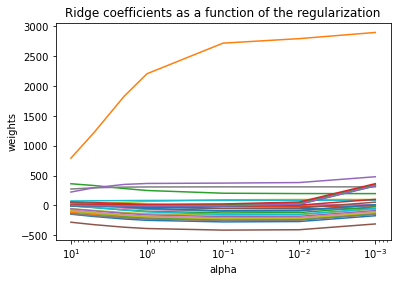

In [143]:
alphas = [1e-3, 1e-2, 1e-1, 1, 2, 5, 10]
coefs = []
for a in alphas:
    ridge = Ridge(alpha=a, fit_intercept=False)
    ridge.fit(X_train, y_train)
    coefs.append(ridge.coef_)

ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

### - KNN Regressor

In [144]:
knn_param_grid = {'n_neighbors' : list(range(10, 100)),
              }

In [145]:
CV_knn = GridSearchCV(estimator=KNeighborsRegressor(), param_grid=knn_param_grid, cv= 6,scoring='r2')
CV_knn.fit(X_train, y_train)

GridSearchCV(cv=6, estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': [10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
                                         20, 21, 22, 23, 24, 25, 26, 27, 28, 29,
                                         30, 31, 32, 33, 34, 35, 36, 37, 38, 39, ...]},
             scoring='r2')

In [146]:
CV_knn.best_score_

0.2655328158973051

In [147]:
model_knn = CV_knn.best_estimator_

In [148]:
model_knn.score(X_test,y_test)

0.24517472980989985

In [149]:
CV_knn.best_params_

{'n_neighbors': 21}

In [150]:
pd.DataFrame(CV_knn.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,mean_test_score,std_test_score,rank_test_score
0,0.001995,0.000003,0.005215,0.000591,10,{'n_neighbors': 10},0.239306,0.248983,0.237243,0.258456,0.443246,0.096452,0.253948,0.100976,18
1,0.002053,0.000588,0.004954,0.000465,11,{'n_neighbors': 11},0.224621,0.235810,0.294121,0.212625,0.437696,0.156313,0.260198,0.089043,8
2,0.002242,0.000541,0.004617,0.001029,12,{'n_neighbors': 12},0.210287,0.228949,0.314322,0.215540,0.441201,0.157361,0.261277,0.092846,5
3,0.002061,0.000153,0.004746,0.000636,13,{'n_neighbors': 13},0.200625,0.259594,0.319224,0.233641,0.414608,0.137949,0.260940,0.088055,6
4,0.001879,0.000277,0.005103,0.000389,14,{'n_neighbors': 14},0.247248,0.263735,0.314171,0.206774,0.400884,0.153416,0.264371,0.078568,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,0.001988,0.000574,0.005673,0.000683,95,{'n_neighbors': 95},0.101542,0.138414,0.302866,0.255584,0.175571,0.313516,0.214582,0.080999,86
86,0.002155,0.000695,0.005457,0.000734,96,{'n_neighbors': 96},0.100380,0.138350,0.300760,0.253893,0.174344,0.314993,0.213787,0.081162,87
87,0.002158,0.000393,0.006008,0.000600,97,{'n_neighbors': 97},0.100165,0.137444,0.298791,0.252085,0.172707,0.314367,0.212593,0.080856,88
88,0.001733,0.000537,0.005713,0.000679,98,{'n_neighbors': 98},0.099377,0.136084,0.297283,0.250061,0.171691,0.313793,0.211382,0.080781,89


### - XGBoost

In [151]:
xgboost_param_grid = {'n_estimators' : [100,200,300,400,500],
              'max_features': ['auto', 'sqrt', 'log2'],
              'max_depth' : [4,8,16,32,64],
              'random_state': [12]}

In [154]:
CV_xgboost = GridSearchCV(estimator=GradientBoostingRegressor(), param_grid=xgboost_param_grid, cv= 5,scoring='r2')
CV_xgboost.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(),
             param_grid={'max_depth': [4, 8, 16, 32, 64],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [100, 200, 300, 400, 500],
                         'random_state': [12]},
             scoring='r2')

In [155]:
CV_xgboost.best_score_

0.6325539548687196

In [156]:
model_boosted = CV_xgboost.best_estimator_

In [157]:
model_boosted.score(X_test,y_test)

0.7745481674195466

In [158]:
pd.DataFrame(CV_xgboost.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_n_estimators,param_random_state,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.170476,0.003787,0.002165,0.000489,4,auto,100,12,"{'max_depth': 4, 'max_features': 'auto', 'n_es...",0.693415,0.501074,-0.562763,0.668743,0.588282,0.377750,0.475062,51
1,0.342987,0.002599,0.002194,0.000403,4,auto,200,12,"{'max_depth': 4, 'max_features': 'auto', 'n_es...",0.694882,0.439962,-0.568851,0.670715,0.558596,0.359061,0.472712,52
2,0.532288,0.009105,0.002985,0.000631,4,auto,300,12,"{'max_depth': 4, 'max_features': 'auto', 'n_es...",0.695776,0.417235,-0.580349,0.674370,0.547533,0.350913,0.476206,53
3,0.717261,0.005894,0.003377,0.000470,4,auto,400,12,"{'max_depth': 4, 'max_features': 'auto', 'n_es...",0.695622,0.408602,-0.591309,0.674289,0.547841,0.347009,0.480252,54
4,0.865631,0.016360,0.002522,0.000605,4,auto,500,12,"{'max_depth': 4, 'max_features': 'auto', 'n_es...",0.695774,0.408122,-0.596054,0.674804,0.542161,0.344962,0.481716,55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,0.174260,0.001791,0.004678,0.000763,64,log2,100,12,"{'max_depth': 64, 'max_features': 'log2', 'n_e...",0.595218,0.462526,0.651078,0.686854,0.486655,0.576466,0.088490,31
71,0.340644,0.006128,0.007413,0.000495,64,log2,200,12,"{'max_depth': 64, 'max_features': 'log2', 'n_e...",0.595231,0.462527,0.651053,0.686859,0.486654,0.576465,0.088487,33
72,0.384187,0.006273,0.008434,0.000450,64,log2,300,12,"{'max_depth': 64, 'max_features': 'log2', 'n_e...",0.595231,0.462527,0.651053,0.686859,0.486654,0.576465,0.088487,35
73,0.399741,0.005583,0.008129,0.000679,64,log2,400,12,"{'max_depth': 64, 'max_features': 'log2', 'n_e...",0.595231,0.462527,0.651053,0.686859,0.486654,0.576465,0.088487,35
